In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import AdaBoostClassifier

from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

2024-07-22 19:08:10.026152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 19:08:10.026216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 19:08:10.026755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 19:08:10.032040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target='DayAfterMajorReversal')
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
targetdf.head()

(2371,)


,Target
date,
1/13/2015,HOLD
1/14/2015,HOLD
1/15/2015,HOLD
1/16/2015,HOLD
1/20/2015,BUY


In [3]:
# make sure we split train and test data with shuffle OFF
X_train, X_test, y_train, y_test = train_test_split(stockdf,y_orig, train_size=0.8,shuffle=False)
# other_test will be used later to help evaluate the efficacy of our predictions, by calculating a return on investment
other_test = otherdf.iloc[-y_test.shape[0]:]

#my stockutils does not remove the index, so...
#y_test.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)


#Problem is for cross validation splits, this won't work, so...

# use a TimeSeriesSplit to do cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

In [4]:
y_test.shape

(475,)

In [5]:
wandb.login(key=os.environ.get("WANDB_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: candrews1971 (christopherandrews). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Base ROI

In [6]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 174.15, cash balance: $1135.3000000000002
Buying 7 shares for 142.99. Remaining Balance: 134.37000000000012
Selling all shares for 153.34, cash balance: $1207.7500000000002
Buying 8 shares for 146.87. Remaining Balance: 32.79000000000019
Selling all shares for 148.01, cash balance: $1216.8700000000001
Buying 9 shares for 129.62. Remaining Balance: 50.29000000000019
Selling all shares for 153.71, cash balance: $1433.6800000000003
Buying 9 shares for 145.91. Remaining Balance: 120.49000000000024
Selling all shares for 195.60, cash balance: $1880.9350000000002
Buying 10 shares for 174.49. Remaining Balance: 136.03500000000008
Selling all shares for 182.91, cash balance: $1965.135
Buying 11 shares for 173.75. Remaining Balance: 53.88499999999999
Selling all shares for 178.85, cash balance: $2021.235
Buying 12 shares for 168.22. Remaining Balance: 2.5950000000000273
Selling all shares for 197.57, cash ba

# Decision Tree Classifier

In [7]:
#wandb.init(entity="christopherandrews", project="StockPredictor", name="DecisionTreeClassifier_v01", save_code=False)

In [8]:
y_test.head()

date
7/26/2022    BUY
7/27/2022    BUY
7/28/2022    BUY
7/29/2022    BUY
8/1/2022     BUY
Name: Target, dtype: category
Categories (3, object): ['BUY', 'HOLD', 'SELL']

In [9]:

# Create the DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=2)

#set up for a Grid Search 
dtc_param_grid = {'max_depth':[1,2,3,4,5,6,7], 
                  'min_samples_split': [2,4,8,16,32,64], 
                  'min_samples_leaf': [2,4,8,16,32,64]}

#log to weights and biases
run_name = f"DecisionTreeClassifier_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)

#Perform the training with a grid search
dtc_gs = GridSearchCV(dt, param_grid=dtc_param_grid, cv=tscv, scoring='accuracy', verbose=True)
dtc_gs.fit(X_train, y_train)

y_pred = dtc_gs.predict(X_test) #uses best estimator

#log accuracy score
run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
dtc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
dtc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(dtc_preds, init_value=1000, init_price=dtc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Fitting 10 folds for each of 252 candidates, totalling 2520 fits
Accuracy:  0.52
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 161.38, cash balance: $1058.68
Buying 6 shares for 163.43. Remaining Balance: 78.10000000000002
Selling all shares for 150.77, cash balance: $982.7200000000001
Buying 6 shares for 142.41. Remaining Balance: 128.2600000000001
Selling all shares for 138.38, cash balance: $958.5400000000001
Buying 6 shares for 150.04. Remaining Balance: 58.30000000000007
Selling all shares for 140.94, cash balance: $903.94
Buying 6 shares for 133.49. Remaining Balance: 103.0
Selling all shares for 145.31, cash balance: $974.86
Buying 6 shares for 153.83. Remaining Balance: 51.879999999999995
Selling all shares for 181.99, cash balance: $1143.8200000000002
Buying 6 shares for 181.12. Remaining Balance: 57.100000000000136
Selling all shares for 174.21, cash balance: $1102.3600000000001
Buying 6 shares for 174.91. Remaining Balance: 52.900000

Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,173.54
accuracy,0.52


In [10]:
#In case the above fails
#run.finish()

<Axes: >

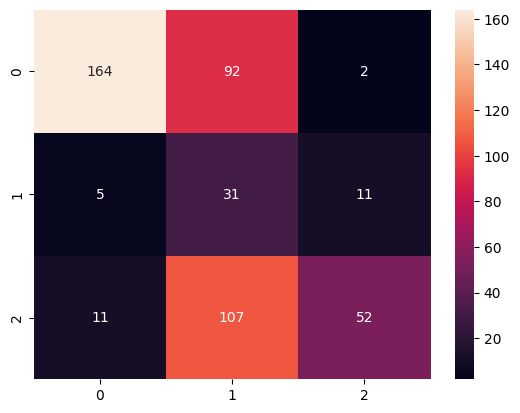

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

Hold seems to be a problem...

In [12]:
logged_config = dtc_gs.best_params_
logged_config["Model"] = "DecisionTreeClassifier"

56% accuracy, hmmm...  that's hardly better than just a guess!

In [13]:
# Get the best paramters from the model
dtc_gs.best_params_

{'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 64,
 'Model': 'DecisionTreeClassifier'}

In [14]:
outputfilepath = os.path.join(IMAGES_PATH, "GridSearchDTC.dot")
export_graphviz(dtc_gs.best_estimator_, out_file=outputfilepath, feature_names=X_train.columns, class_names=["BUY","HOLD",'SELL'], rounded=True, filled=True )

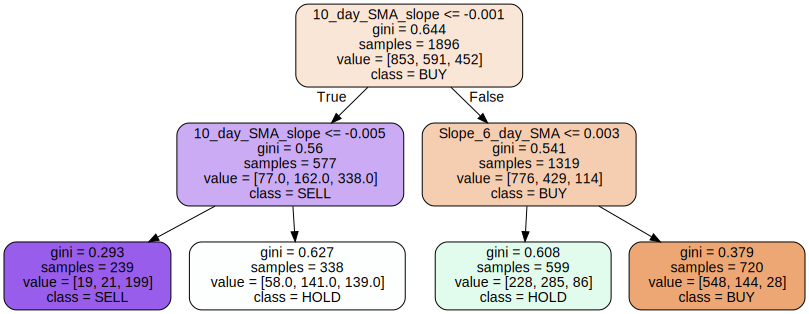

In [15]:
Source.from_file(outputfilepath)

<Axes: >

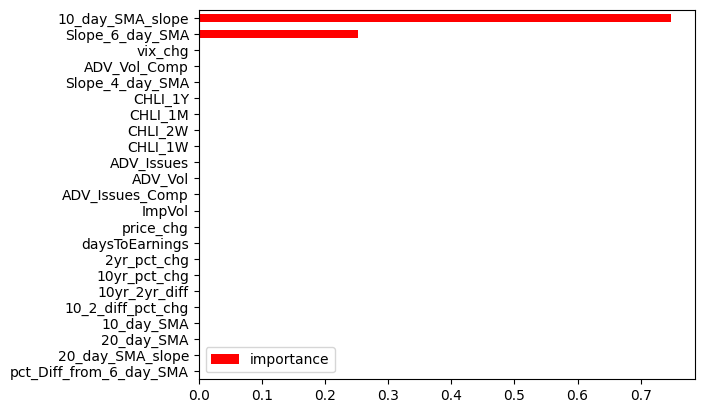

In [16]:
feature_importances = list(zip(X_train.columns, dtc_gs.best_estimator_.feature_importances_))
fi = pd.Series(dtc_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

It only seems to want to use the 6 and 10 day SMA slope...

# AdaBoost Classifier


In [17]:
adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
                  'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"AdaBoostClassifier_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)

adb_clf = AdaBoostClassifier(estimator=dt, algorithm='SAMME', n_estimators=200, random_state=42)

adb_gs = GridSearchCV(adb_clf, param_grid=adb_param_grid, cv=tscv, scoring='accuracy', verbose=True)

adb_gs.fit(X_train, y_train)

y_pred = adb_gs.predict(X_test) #uses best estimator

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))


# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
adb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
adb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(adb_preds, init_value=1000, init_price=adb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Accuracy:  0.6421052631578947
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 163.62, cash balance: $1072.1200000000001
Buying 6 shares for 163.43. Remaining Balance: 91.54000000000008
Selling all shares for 153.84, cash balance: $1014.58
Buying 6 shares for 156.90. Remaining Balance: 73.17999999999995
Selling all shares for 150.43, cash balance: $975.76
Buying 6 shares for 142.99. Remaining Balance: 117.81999999999994
Selling all shares for 138.88, cash balance: $951.0999999999999
Buying 6 shares for 146.87. Remaining Balance: 69.87999999999988
Selling all shares for 149.70, cash balance: $968.0799999999998
Buying 6 shares for 150.04. Remaining Balance: 67.8399999999998
Selling all shares for 144.22, cash balance: $933.1599999999997
Buying 6 shares for 148.31. Remaining Balance: 43.29999999999973
Selling all shares for 142.91, cash balance: $900.7599999999998
Buying 6 shares for 144.49

Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,372.06
accuracy,0.64211


<Axes: >

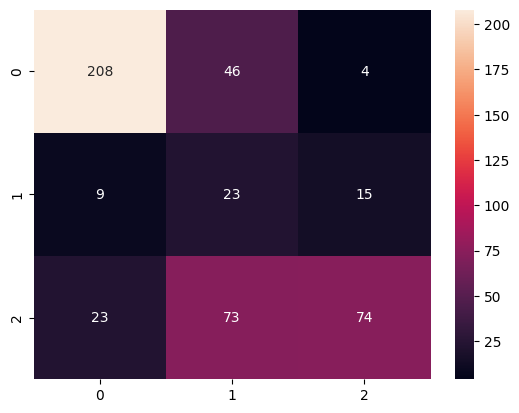

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

<Axes: >

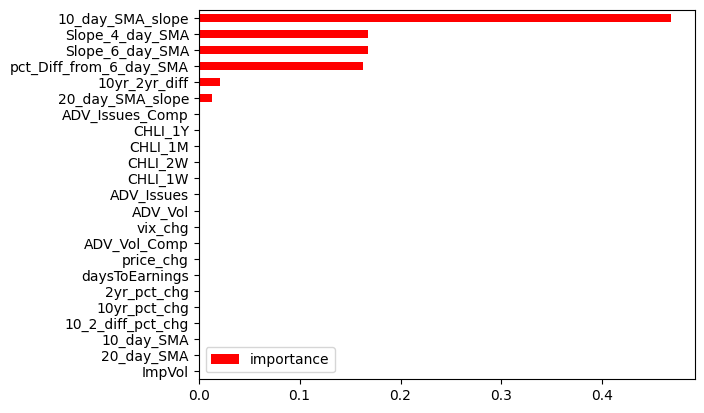

In [19]:
feature_importances = list(zip(X_train.columns, adb_gs.best_estimator_.feature_importances_))
fi = pd.Series(adb_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

We end up using a few more features, and get a fairly surprising 64% accuracy.

# Gradient Boosting Classifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
#                   'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"GradientBoostClassifier_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)


#Use a time series split as the CV
tscv = TimeSeriesSplit(n_splits=8)

gbc = GradientBoostingClassifier(max_depth=2, random_state=42, loss='log_loss')

gbc_params = {'learning_rate':[0.001], 'n_estimators':[ 800]}

#RandomizedSearchCV
gbc_gs = GridSearchCV(gbc, param_grid=gbc_params, cv=tscv, scoring='accuracy', verbose=True)

gbc_gs.fit(X_train, y_train)


y_pred = gbc_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
gbc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
gbc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(gbc_preds, init_value=1000, init_price=gbc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
#wandb.sklearn.plot_roc(y_test, y_probas, ["BUY", "HOLD", "SELL"])
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])
#wandb.sklearn.plot_learning_curve(gbc_gs.best_estimator_, X_train, y_train)
run.finish()

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 167.23, cash balance: $1093.78
Buying 6 shares for 167.53. Remaining Balance: 88.59999999999991
Selling all shares for 163.62, cash balance: $1070.32
Buying 6 shares for 163.43. Remaining Balance: 89.7399999999999
Selling all shares for 153.84, cash balance: $1012.7799999999999
Buying 6 shares for 155.31. Remaining Balance: 80.91999999999985
Selling all shares for 152.37, cash balance: $995.1399999999999
Buying 6 shares for 154.48. Remaining Balance: 68.25999999999999
Selling all shares for 150.43, cash balance: $970.84
Buying 6 shares for 151.76. Remaining Balance: 60.280000000000086
Selling all shares for 142.48, cash balance: $915.16
Buying 6 shares for 142.99. Remaining Balance: 57.219999999999914
Selling all shares for 138.88, cash balance: $890.4999999999999
Buying 6 shares for 146.87. Remaining Balance: 9.279999999999859
Selling all s

Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,196.89
accuracy,0.69684


This is quite slow compared to XGBoost

In [21]:
run.finish()

In [22]:
gbc_gs.best_params_

{'learning_rate': 0.001, 'n_estimators': 800}

<Axes: >

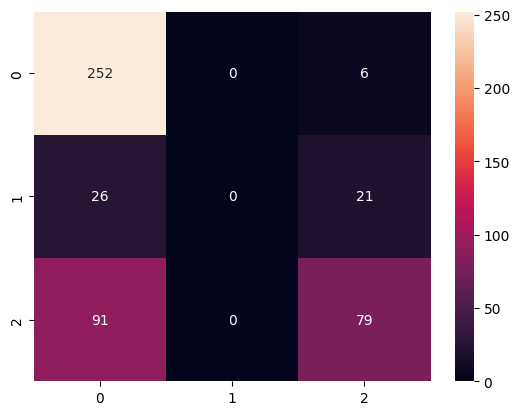

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

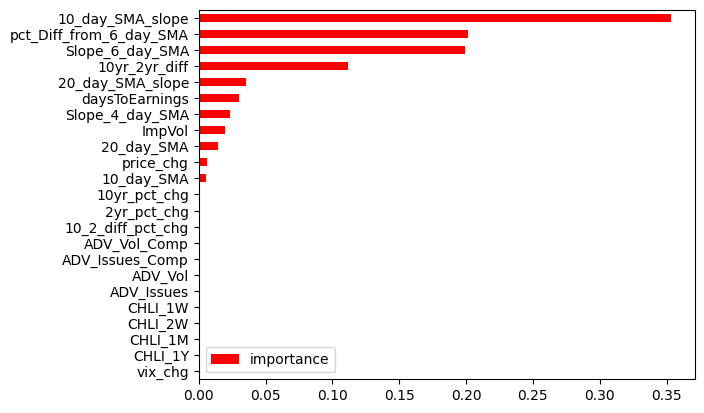

In [24]:
stockutils.plot_feature_importances(X_train=X_train, estimator=gbc_gs.best_estimator_)



BUT, it always predicts a buy or sell, never hold!  

# Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:

#log to weights and biases
run_name = f"RandomForestClassifier_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

#tscv = TimeSeriesSplit(n_splits=8)
tscv = 10

#cls = StackingClassifier(max_depth=2, random_state=42, loss='log_loss')
cls = RandomForestClassifier(random_state=42)

#Base classifier 
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

print("Base classifier accuracy:", accuracy_score(y_test, y_pred))


#gbc_params = {'learning_rate':[0.001, 0.01, 0.1, 1, 10], 'n_estimators':[100,200,300]}
cls_params = {'max_depth':[2, 4, 6], 'n_estimators':[100, 200, 400, 800, 1000], 'max_features': [2, 4, 6 ]}

rf_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='accuracy', verbose=True)

rf_gs.fit(X_train, y_train)

y_pred = rf_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text("hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in rf_gs.best_params_.items()]))
)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
rf_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
rf_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(rf_preds, init_value=1000, init_price=rf_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Base classifier accuracy: 0.5852631578947368
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 167.23, cash balance: $1093.78
Buying 6 shares for 157.37. Remaining Balance: 149.55999999999995
Selling all shares for 153.84, cash balance: $1072.6
Buying 6 shares for 156.90. Remaining Balance: 131.19999999999982
Selling all shares for 150.43, cash balance: $1033.7799999999997
Buying 7 shares for 142.99. Remaining Balance: 32.84999999999968
Selling all shares for 138.38, cash balance: $1001.5099999999996
Buying 7 shares for 142.41. Remaining Balance: 4.639999999999645
Selling all shares for 138.88, cash balance: $976.7999999999996
Buying 6 shares for 146.87. Remaining Balance: 95.57999999999959
Selling all shares for 144.22, cash balance: $960.8999999999995
Buying 6 shares for 148.31. Remaining Balance: 71.03999999999951
Selling all shares for 142.91, cash balance: $928.4999999999995
Buying

2024-07-22 19:16:16.975425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 19:16:16.975485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 19:16:16.976067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 19:16:16.982125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,337.52
accuracy,0.66947


In [27]:
wandb.finish()

In [28]:
rf_gs.best_params_

{'n_estimators': 1000, 'max_features': 6, 'max_depth': 2}

<Axes: >

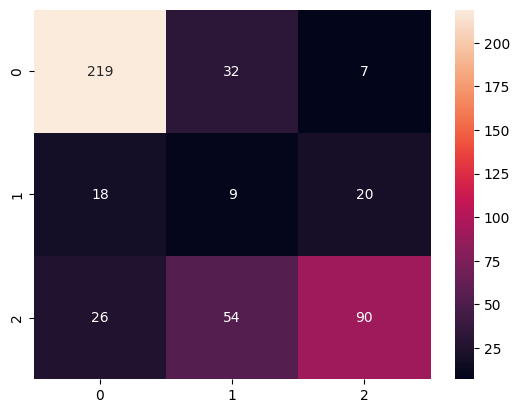

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

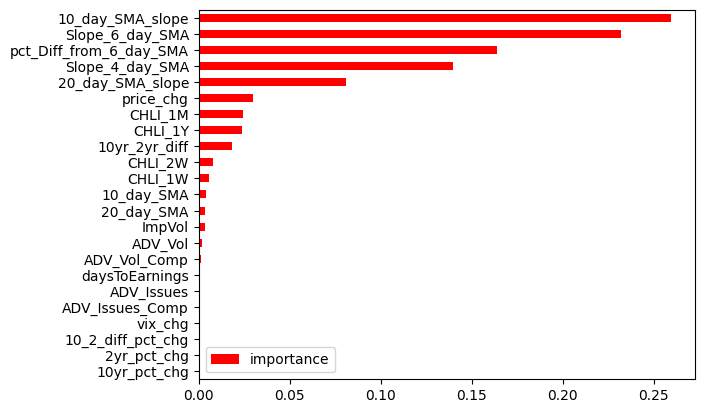

In [30]:

stockutils.plot_feature_importances(X_train=X_train, estimator=rf_gs.best_estimator_)

# PCA 
Out of curiosity, what does affect does running PCA on the data prior to training end up with?

In [31]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

# yay! this is nice!  now our transform creates a pandas dataframe instead of numpy array
set_config(transform_output="pandas")

pca_scaler = StandardScaler()
pca = PCA(n_components=5)

pipeline = make_pipeline(pca_scaler, pca)

pipeline.fit(X_train)
pca.get_feature_names_out(input_features=X_train.columns)

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4'], dtype=object)

In [32]:
transformed = pca.transform(X_train)
print(transformed.shape)

(1896, 5)


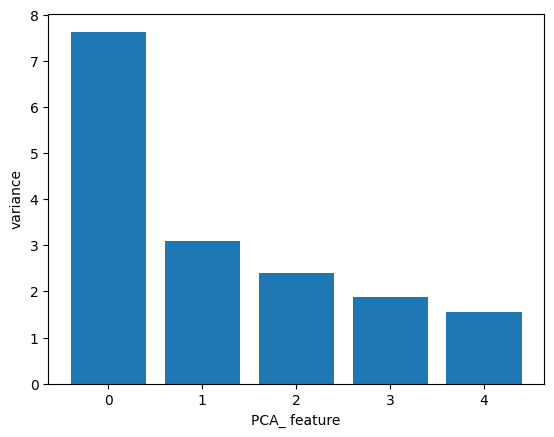

In [33]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA_ feature')
plt.show()

In [34]:
#rf_gs.fit(transformed, y_train)

#y_pred = rf_gs.predict(pca.transform(X_test))

In [35]:
#print("Accuracy: ", accuracy_score(y_test, y_pred))

30%, hmm... that's pretty bad

# XGBoost

In [36]:

#y_train_xgb = pd.Categorical(y_train['Target']).codes
y_train_xgb = pd.Categorical(y_train).codes

#y_test_xgb = pd.Categorical(y_test['Target']).codes
y_test_xgb = pd.Categorical(y_test).codes

In [37]:
import xgboost as xgb

#log to weights and biases
run_name = f"XGBoostClassifier_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

tscv = 10

evals = [(X_train, y_train_xgb), (X_test, y_test_xgb)]



cls = xgb.XGBClassifier(objective='multi:softmax', 
                        num_class=3,
                        n_estimators=500, 
                        seed=42, 
                        importance_type='gain', 
                        device="cuda",
                        early_stopping_rounds=20,
                        eval_metric=['merror', 'mlogloss'],
                        callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")]
                        ) 
#Base classifier 
cls.fit(X_train, y_train_xgb, eval_set=evals)
y_pred_train_xgb = cls.predict(X_train)
y_pred_test_xgb = cls.predict(X_test)

print("Base classifier training set accuracy:", accuracy_score(y_train_xgb, y_pred_train_xgb))
print("Base classifier test set accuracy:", accuracy_score(y_test_xgb, y_pred_test_xgb))
print("Base classifier params:", cls.get_params())

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# cls_params = {
#     'learning_rate':[0.001,0.01, 0.1, 0.2, 1, 10],
#     'max_depth':[1,2],
#     'subsample':[ 0.2, 0.5, 0.7, 0.8, 0.9]
# }

cls_params = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate':[0.001, 0.01, 0.1],
    'max_depth':[2, 4, 6],
    'subsample':[ 0.1, 0.2]
}
xgb_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='accuracy', verbose=False)

#xgb_gs = GridSearchCV(cls, param_grid=cls_params, cv=tscv, scoring='accuracy', verbose=False)

xgb_gs.fit(X_train, y_train_xgb, eval_set=evals)

y_pred = xgb_gs.predict(X_test)

run.summary['accuracy'] = accuracy_score(y_test_xgb, y_pred)


# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
xgb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Test Accuracy: ", accuracy_score(y_test_xgb, y_pred))
print("Best Params", xgb_gs.best_params_)

wandb.sklearn.plot_confusion_matrix(y_test_xgb, y_pred)

run.finish()

[0]	validation_0-merror:0.15823	validation_0-mlogloss:0.87087	validation_1-merror:0.47158	validation_1-mlogloss:1.01990
[1]	validation_0-merror:0.12922	validation_0-mlogloss:0.72751	validation_1-merror:0.48000	validation_1-mlogloss:0.98377
[2]	validation_0-merror:0.10812	validation_0-mlogloss:0.61776	validation_1-merror:0.42316	validation_1-mlogloss:0.94281
[3]	validation_0-merror:0.09705	validation_0-mlogloss:0.53717	validation_1-merror:0.42105	validation_1-mlogloss:0.91199
[4]	validation_0-merror:0.08122	validation_0-mlogloss:0.47024	validation_1-merror:0.45053	validation_1-mlogloss:0.92363
[5]	validation_0-merror:0.07278	validation_0-mlogloss:0.42373	validation_1-merror:0.42316	validation_1-mlogloss:0.89782
[6]	validation_0-merror:0.06276	validation_0-mlogloss:0.37870	validation_1-merror:0.42947	validation_1-mlogloss:0.89823
[7]	validation_0-merror:0.05696	validation_0-mlogloss:0.34399	validation_1-merror:0.42316	validation_1-mlogloss:0.89759
[8]	validation_0-merror:0.04958	validati

/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:16:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1706051839871/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Base classifier training set accuracy: 0.9562236286919831
Base classifier test set accuracy: 0.6
Base classifier params: {'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': [<wandb.integration.xgboost.xgboost.WandbCallback object at 0x7f9d12cc4460>], 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': 20, 'enable_categorical': False, 'eval_metric': ['merror', 'mlogloss'], 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'sca

wandb: Network error (TransientError), entering retry loop.


[86]	validation_0-merror:0.19198	validation_0-mlogloss:0.75507	validation_1-merror:0.28632	validation_1-mlogloss:0.87436
[87]	validation_0-merror:0.19040	validation_0-mlogloss:0.75277	validation_1-merror:0.28421	validation_1-mlogloss:0.87292
[88]	validation_0-merror:0.18882	validation_0-mlogloss:0.74976	validation_1-merror:0.28421	validation_1-mlogloss:0.87065
[89]	validation_0-merror:0.19146	validation_0-mlogloss:0.74731	validation_1-merror:0.28421	validation_1-mlogloss:0.86952
[90]	validation_0-merror:0.19251	validation_0-mlogloss:0.74487	validation_1-merror:0.28632	validation_1-mlogloss:0.86901
[91]	validation_0-merror:0.19251	validation_0-mlogloss:0.74266	validation_1-merror:0.28421	validation_1-mlogloss:0.86682
[92]	validation_0-merror:0.19198	validation_0-mlogloss:0.74005	validation_1-merror:0.28632	validation_1-mlogloss:0.86590
[93]	validation_0-merror:0.19251	validation_0-mlogloss:0.73768	validation_1-merror:0.28632	validation_1-mlogloss:0.86481
[94]	validation_0-merror:0.19146

best_iteration,▁████▄▄▃▃███▅▅▂▄████▄▄▄▄▄▄▄▃▄▄▄▄▂▂▄▂███▄
best_score,▅▄▅▄▄▂▂▁▂███▁▁▃▁████▆▆▆▆▂▂▂▂▆▆▆▆▂▂▁▂███▆
epoch,▃▅▅▄▄▃▂▂▁█▇▇▆▆▂▃▅▅▅▄▃▃▂▂▁▃▃▄▄▃▂▅▅▃▃▂▂▁█▇
validation_0-merror,▃▂▁▃▂▂▄▅▃▃▂▃▂▂█▆▅▅▆▅▆▆▇▇█▂▁▁▁▄▅▅▄▆▇▇▇█▇▇
validation_0-mlogloss,▆▅▅▆▆▆▃▄█▇▇▇██▄▃▃█████▇▇█▂▂▁▁▇▇▃▃▃██████
validation_1-merror,▅▄▅▆▃▃▄▃█▃▄▇▃▁▃▅▂▃▄▅▃▃▃▄▃▄▄▃▃▄▃▃▅▃▄▃▃▃▃▂
validation_1-mlogloss,▆▅▆▆▆▇▂▃█▇▇█▇█▂▂▁█████▇▇█▂▂▂▃▇▇▁▂▂████▇▇
Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,324.96
accuracy,0.73684


In [38]:
results = xgb_gs.best_estimator_.evals_result()


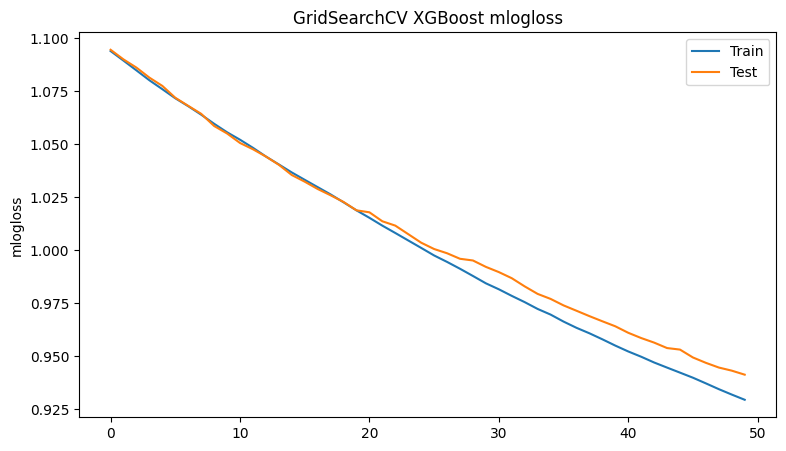

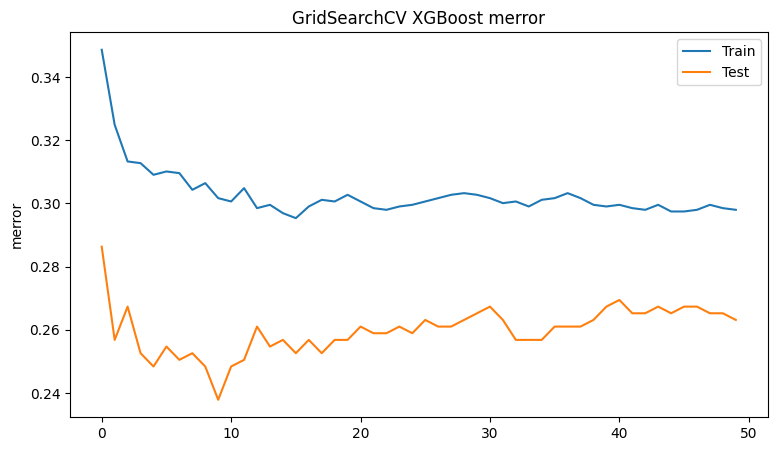

In [39]:
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [40]:
run.finish()

# XGBoost #2 using native API ( DMatrix, etc)

In [41]:
# we will change our main dataset slightly
#stockdf, targetdf, otherdf
from sklearn.preprocessing import OrdinalEncoder


In [42]:
y_train_xgb = pd.Categorical(y_train).codes
y_test_xgb = pd.Categorical(y_test).codes

y_encoded = OrdinalEncoder().fit_transform(targetdf)


#X_train, X_test, y_train, y_test = train_test_split(stockdf,y_encoded, train_size=0.8,shuffle=False)


train_xgb = xgb.DMatrix(X_train, y_train_xgb, enable_categorical=True)

test_xgb = xgb.DMatrix(X_test, y_test_xgb, enable_categorical=True)

In [43]:
import xgboost as xgb
from wandb.integration.xgboost import WandbCallback

run_name = f"XGBoostClassNative_shuffled_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

params = {"objective": "multi:softmax"
        , "device":"cuda"
        ,"num_class":3
        , 'max_depth': 2
        , 'learning_rate': 0.001
        , 'random_state': 42
        , 'eval_metric': ['auc']}

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# params = {
#         "objective": "multi:softprob"
#         , "num_class":3
#         , 'gamma': 1               ## def: 0
#         , 'learning_rate': 0.1     ## def: 0.1
#         , 'max_depth': 3
#         , 'min_child_weight': 100  ## def: 1
#         , 'nthread': 24
#         , 'random_state': 42
#         , 'reg_alpha': 0
#         , 'reg_lambda': 0          ## def: 1
#         , 'eval_metric': ['auc', 'logloss']
#         , "device":"cuda" # use to train on GPU
#     }

evals = [(train_xgb, "train"), (test_xgb, "test")]
num_rounds = 100000

cls2 = xgb.train(params=params, 
                dtrain=train_xgb, 
                num_boost_round=num_rounds, 
                evals=evals, 
                verbose_eval=10, 
                early_stopping_rounds=200, 
                callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")])

y_pred_test_xgb = cls2.predict(test_xgb, iteration_range=(0, cls2.best_iteration + 1))

run.summary['accuracy'] = accuracy_score(y_test_xgb, y_pred_test_xgb)
print("Test Accuracy: ", accuracy_score(y_test_xgb, y_pred_test_xgb))
xgb_preds = pd.DataFrame(data=y_pred_test_xgb, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test_xgb, y_pred_test_xgb)

run.finish()


[0]	train-auc:0.82990	test-auc:0.84715
[10]	train-auc:0.82990	test-auc:0.84715
[20]	train-auc:0.82990	test-auc:0.84715
[30]	train-auc:0.82990	test-auc:0.84715
[40]	train-auc:0.83284	test-auc:0.84842
[50]	train-auc:0.83286	test-auc:0.84839
[60]	train-auc:0.83277	test-auc:0.84999
[70]	train-auc:0.83807	test-auc:0.85416
[80]	train-auc:0.83970	test-auc:0.85525
[90]	train-auc:0.84168	test-auc:0.85606
[100]	train-auc:0.84336	test-auc:0.85630
[110]	train-auc:0.84451	test-auc:0.85671
[120]	train-auc:0.84535	test-auc:0.85679
[130]	train-auc:0.84625	test-auc:0.85652
[140]	train-auc:0.84694	test-auc:0.85659
[150]	train-auc:0.84776	test-auc:0.85724
[160]	train-auc:0.84840	test-auc:0.85652
[170]	train-auc:0.84864	test-auc:0.85688
[180]	train-auc:0.84973	test-auc:0.85722
[190]	train-auc:0.84999	test-auc:0.85655
[200]	train-auc:0.85028	test-auc:0.85663
[210]	train-auc:0.85046	test-auc:0.85564
[220]	train-auc:0.85084	test-auc:0.85562
[230]	train-auc:0.85114	test-auc:0.85564
[240]	train-auc:0.85131	tes

best_iteration,▁
best_score,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test-auc,▁▁▁▁▂▂▃▆▇█▇███████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train-auc,▁▁▁▁▂▂▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
Buy And Hold (Base ROI),62.64
Max ROI,2121.475
ROI,299.68
accuracy,0.71789
best_iteration,178
best_score,0.85731


<Axes: >

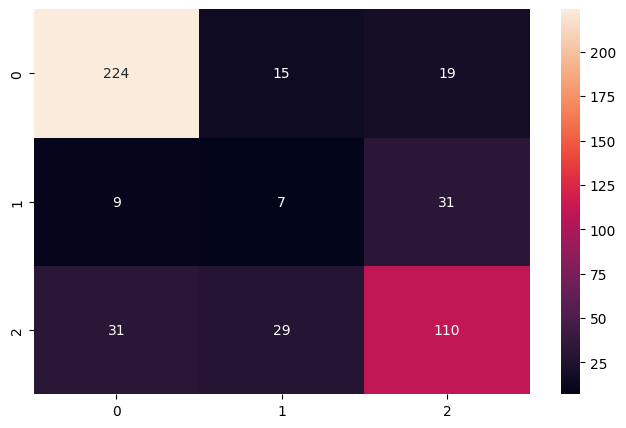

In [44]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_xgb, y_pred_test_xgb), annot=True, fmt="d")

### show the tree 

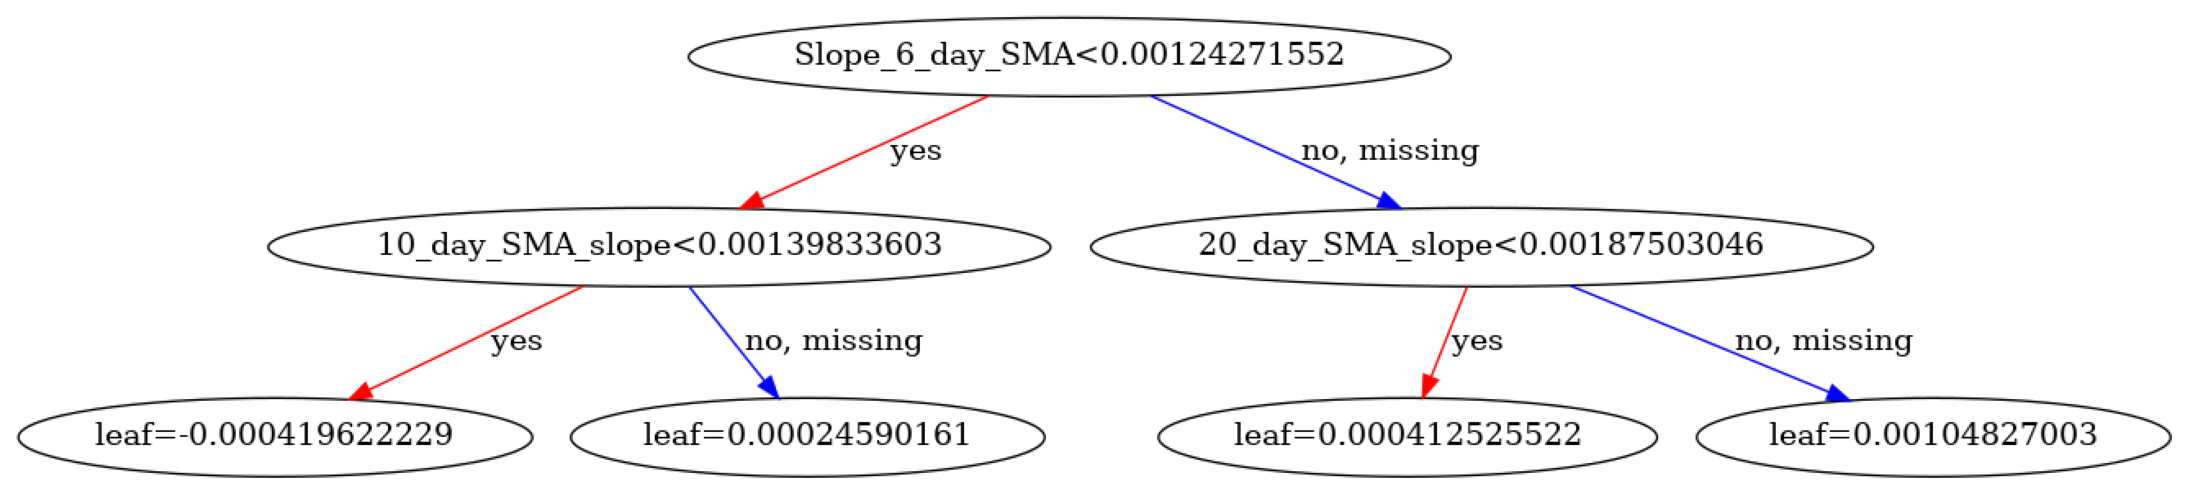

In [45]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28,12
xgb.plot_tree(cls2)
plt.show()

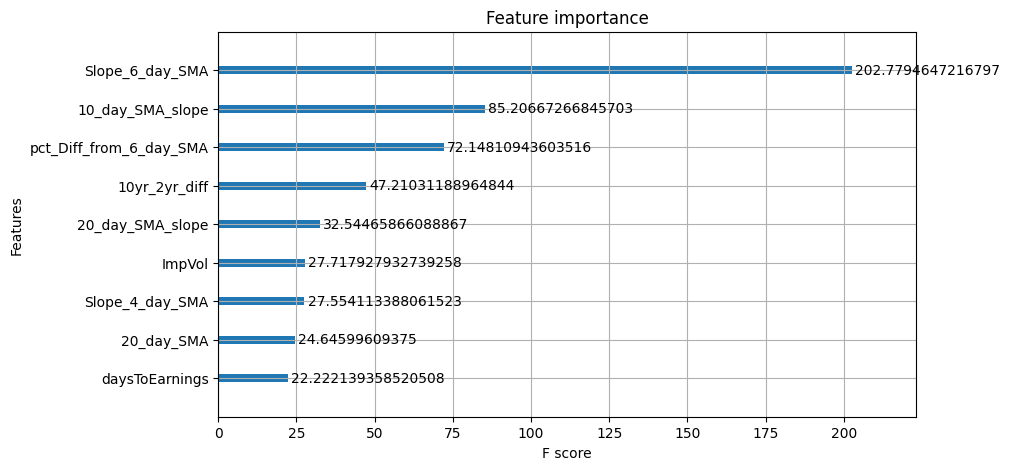

In [46]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(cls2, ax=ax, importance_type="gain")
plt.show()

<Axes: >

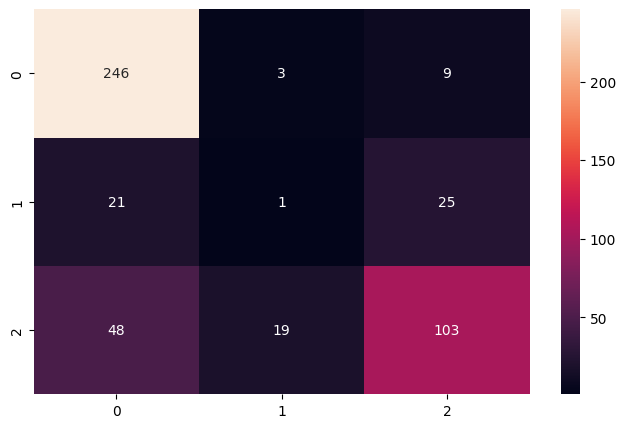

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_xgb, y_pred), annot=True, fmt="d")


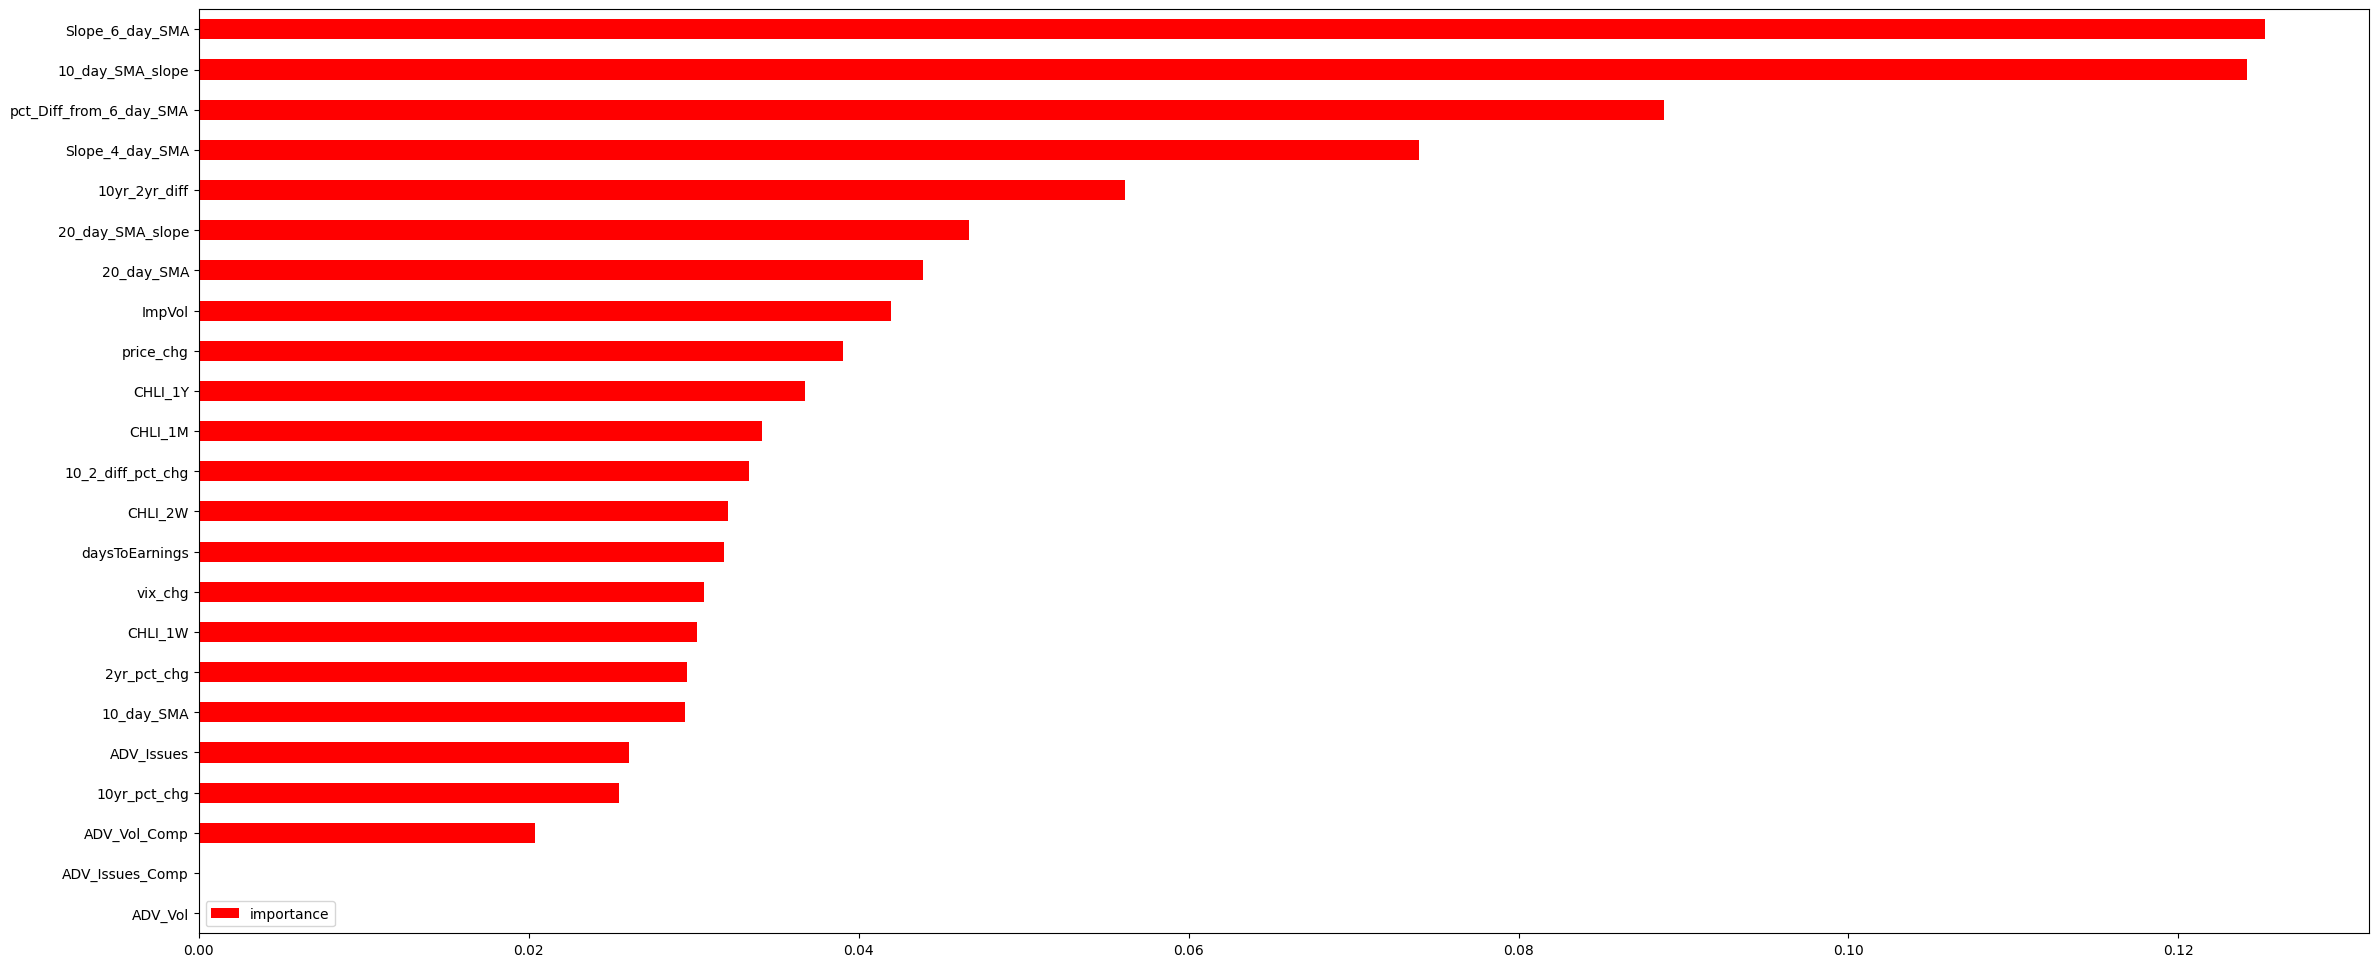

In [48]:
stockutils.plot_feature_importances(X_train=X_train, estimator=xgb_gs.best_estimator_)

XGBoost also has an equivalent feature importance graph

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

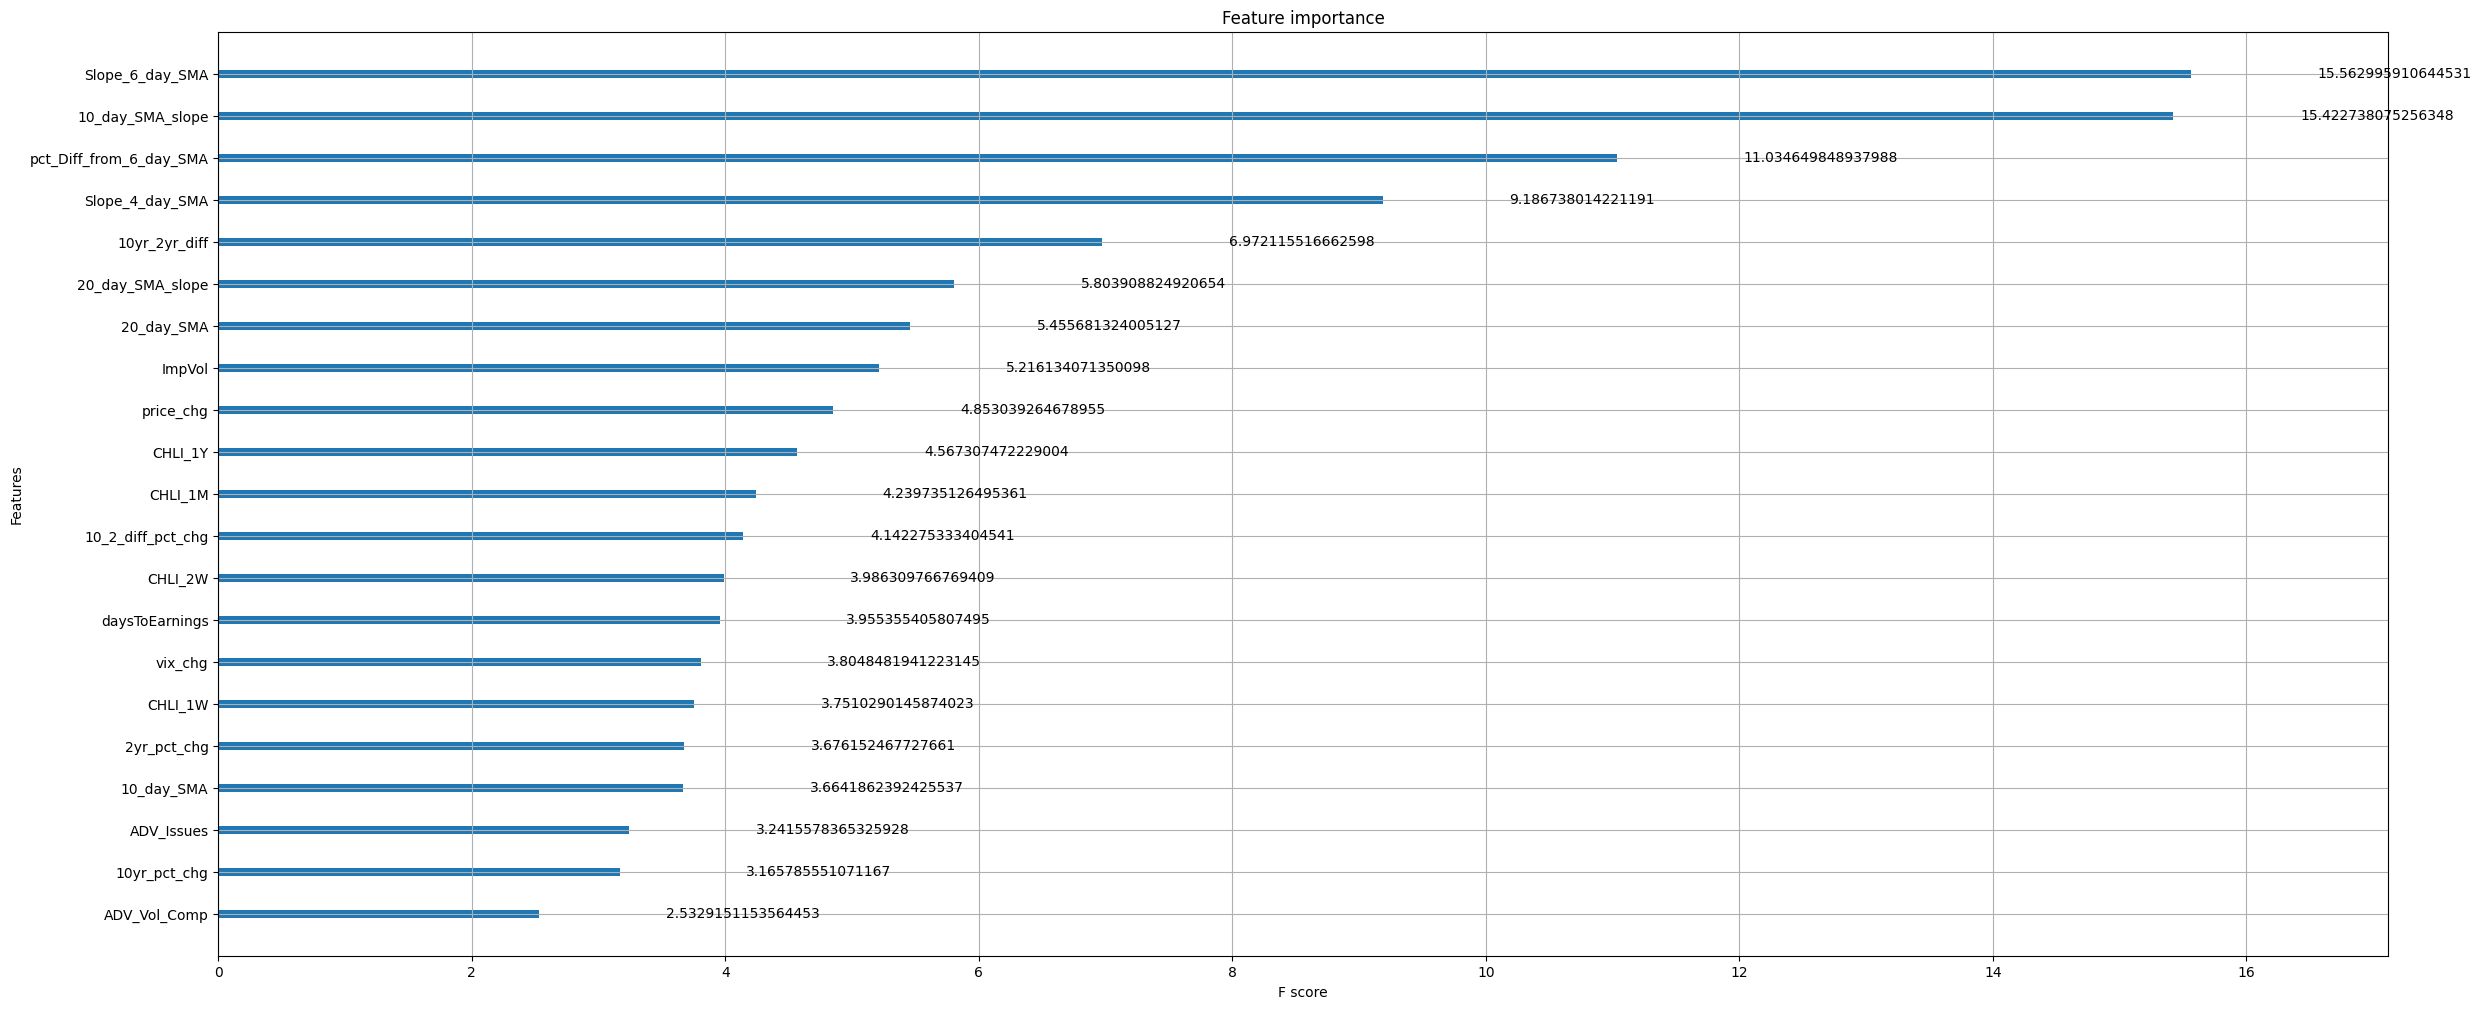

In [49]:
xgb.plot_importance(xgb_gs.best_estimator_, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

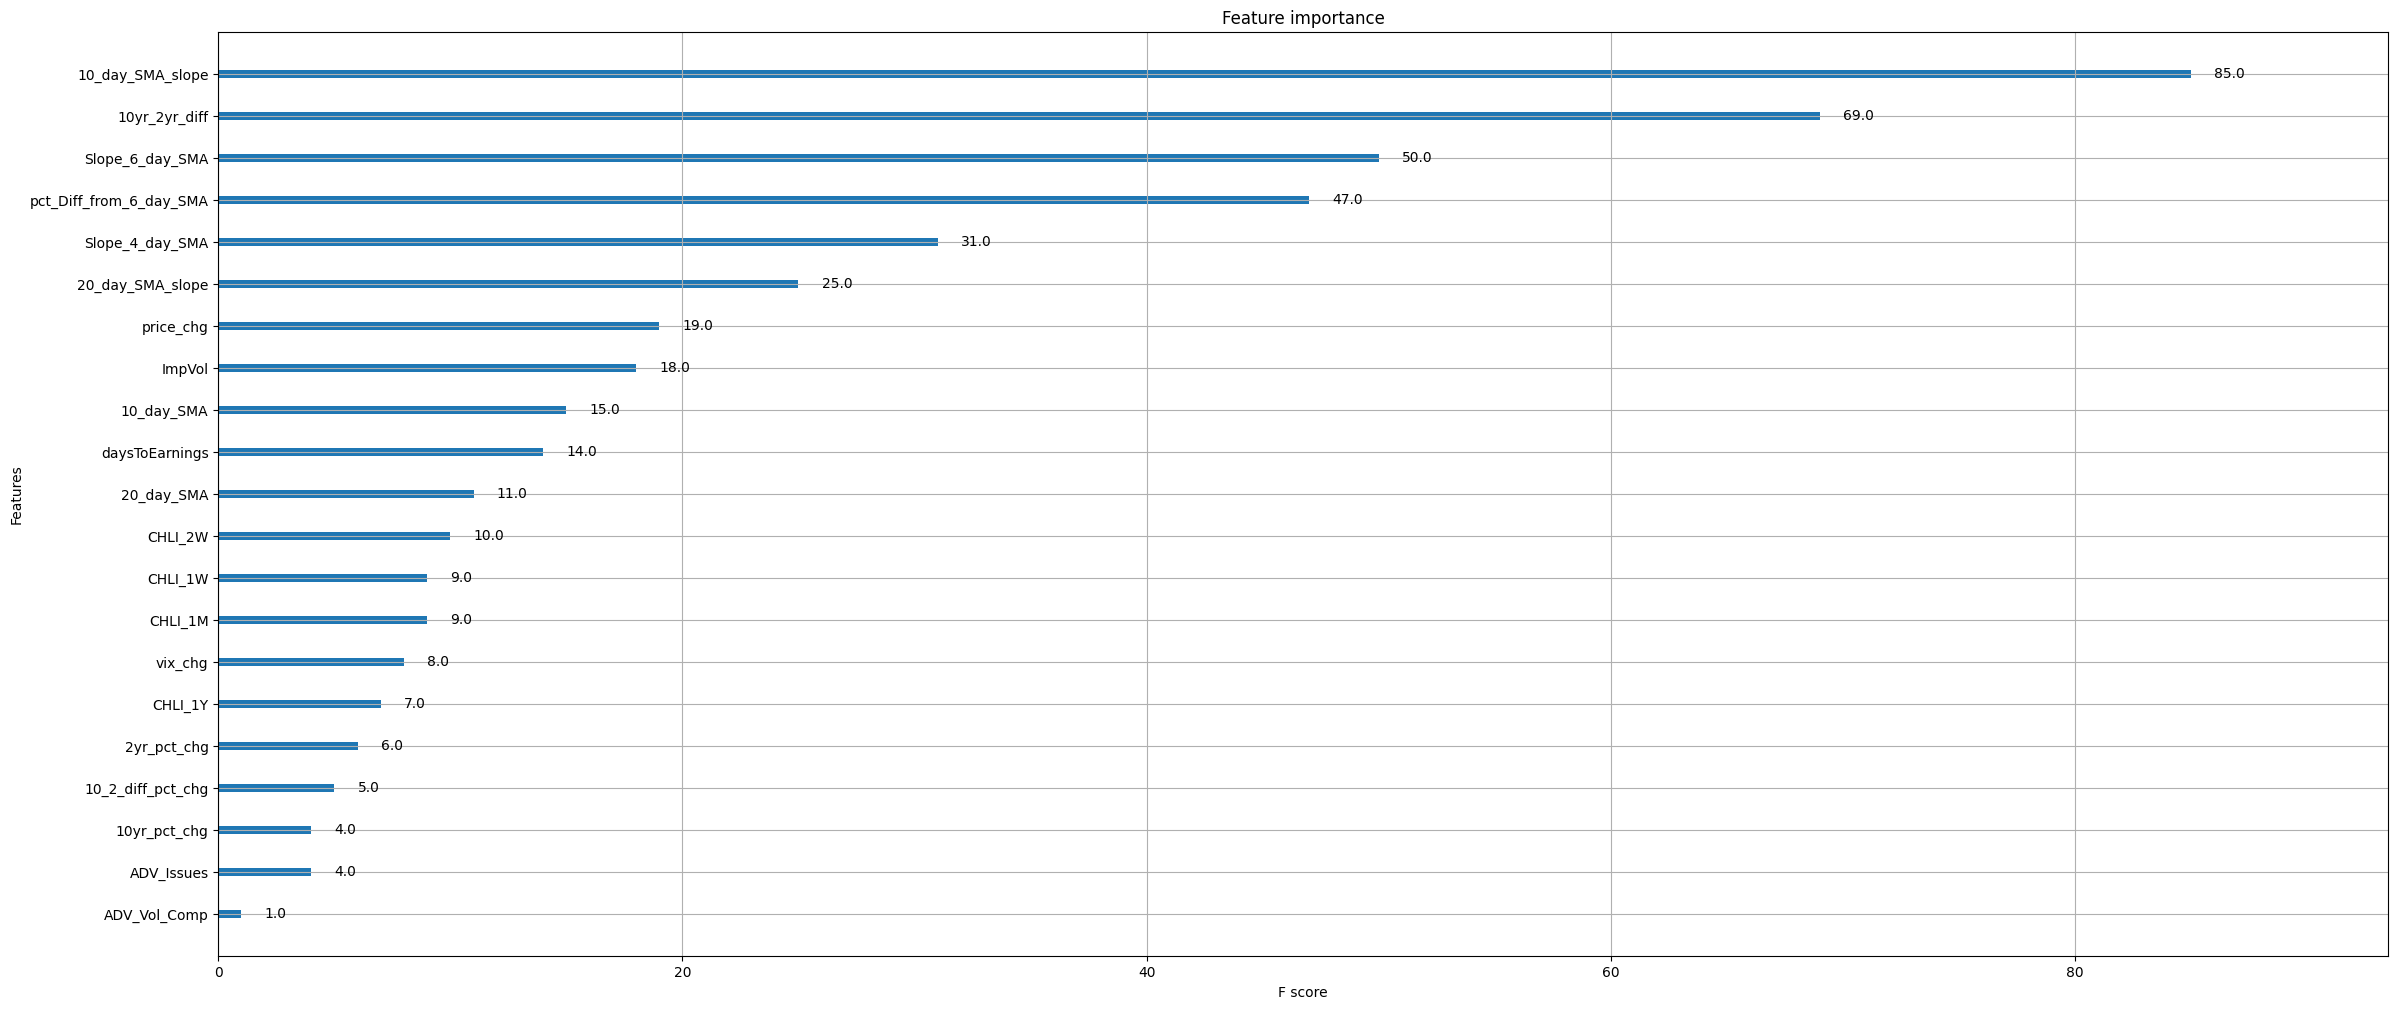

In [50]:
xgb.plot_importance(xgb_gs.best_estimator_)

# How do these models perform on the stock market?  

This won't be quite accurate, (we should use a different stock, or timeframe perhaps) but lets run the model predictions on the full dataset, plot the buys and sells, and then calculate our return

In [51]:
#plop the target value into the otherdf for plotting
otherdf['Target'] = targetdf['Target']

otherdf

,close,vix,2yr_Yield,10yr_Yield,Target
date,,,,,
1/13/2015,27.5550,20.56,0.541,1.905,HOLD
1/14/2015,27.4500,21.48,0.501,1.855,HOLD
1/15/2015,26.7050,22.39,0.420,1.728,HOLD
1/16/2015,26.4975,20.95,0.488,1.831,HOLD
1/20/2015,27.1800,19.89,0.499,1.791,BUY
...,...,...,...,...,...
6/7/2024,196.8900,12.22,4.889,4.433,BUY
6/10/2024,193.1200,12.74,4.885,4.471,BUY
6/11/2024,207.1500,12.85,4.834,4.402,BUY


In [52]:
# gather full predictions on the whole dataset
dtc_y_full_pred = dtc_gs.predict(stockdf)
adb_y_full_pred = adb_gs.predict(stockdf)
gbc_y_full_pred = gbc_gs.predict(stockdf)
rf_y_full_pred = rf_gs.predict(stockdf)

xgb_y_full_pred = xgb_gs.predict(stockdf)

#next, our calculate_total_gains requires a dataframe with date index, and 'close' and 'Target' features.


y_full_xgb = pd.Categorical(y_orig).codes
full_xgb = xgb.DMatrix(stockdf, y_full_xgb, enable_categorical=True)
xgb_native_y_full_pred = cls2.predict(full_xgb)


In [53]:
#dtc_y_full_pred

In [54]:
#dtc_y_full_pred = dtc_gs.predict(stockdf)

In [55]:
dtc_predictions = targetdf.copy()
dtc_predictions['Target'] = dtc_y_full_pred
dtc_predictions['close'] = otherdf['close']

adb_predictions = targetdf.copy()
adb_predictions['Target'] = adb_y_full_pred
adb_predictions['close'] = otherdf['close']

gbc_predictions = targetdf.copy()
gbc_predictions['Target'] = gbc_y_full_pred
gbc_predictions['close'] = otherdf['close']

rf_predictions = targetdf.copy()
rf_predictions['Target'] = rf_y_full_pred
rf_predictions['close'] = otherdf['close']

xgb_predictions = targetdf.copy()
xgb_predictions['Target'] = xgb_y_full_pred
xgb_predictions['close'] = otherdf['close']

xgb_native_predictions = targetdf.copy()
xgb_native_predictions['Target'] = xgb_native_y_full_pred
xgb_native_predictions['close'] = otherdf['close']





In [56]:
import math

def calculate_total_gains(df, init_value, init_price, transaction_cost_fixed=0.0  ):
    price = init_price
    num_shares_owned = 0
    gain = 0.0
    cash_balance = init_value
    for idx, row in df.iterrows():
        price = df.loc[idx,'close']#price + (price * row['price_change_pct'])
        if row["Target"] == 'BUY' or row['Target'] == 0:
            max_shares = math.floor(cash_balance/price)
            if max_shares > 0:
                num_shares_owned += max_shares
                cash_balance = cash_balance - (max_shares*price)
                print("Buying {} shares for {:0.2f}. Remaining Balance: {}".format(max_shares, price, cash_balance))
        elif row["Target"] == 'SELL' or row['Target']== 2:
            cash_balance = cash_balance + (num_shares_owned * price)
            if num_shares_owned != 0:
                print("Selling all shares for {:0.2f}, cash balance: ${}".format(price, cash_balance))
            num_shares_owned = 0
    #sell at the end for gain calculation if we are holding stock
    cash_balance = cash_balance + (num_shares_owned * price)   
    print("Selling all remaining held shares, cash balance: ${} ***********************".format(cash_balance))
    roi = cash_balance - init_value
    return roi

In [57]:
initial_investment = 1000

### Buy and Hold

In [58]:
# Buy and hold performance
starting_price = otherdf['close'][0]
ending_price = otherdf['close'][-1]
print("Starting price:", starting_price)
print("Ending price:", ending_price)
num_shares = math.floor(initial_investment/starting_price)
gain = num_shares*ending_price
gain

Starting price: 27.555
Ending price: 214.24


7712.64

### Ideal

In [59]:
# ideal performance


calculate_total_gains(otherdf, init_value=initial_investment, init_price=otherdf['close'][0])

Buying 36 shares for 27.18. Remaining Balance: 21.519999999999982
Selling all shares for 32.69, cash balance: $1198.27
Buying 43 shares for 27.70. Remaining Balance: 7.384999999999991
Selling all shares for 30.50, cash balance: $1318.885
Buying 56 shares for 23.50. Remaining Balance: 3.025000000000091
Selling all shares for 27.46, cash balance: $1540.925
Buying 68 shares for 22.63. Remaining Balance: 2.0850000000000364
Selling all shares for 25.09, cash balance: $1708.0349999999999
Buying 73 shares for 23.40. Remaining Balance: 0.017499999999699867
Selling all shares for 28.90, cash balance: $2109.535
Buying 78 shares for 26.78. Remaining Balance: 20.889999999999873
Selling all shares for 37.24, cash balance: $2925.9999999999995
Buying 81 shares for 36.05. Remaining Balance: 6.354999999999563
Selling all shares for 41.01, cash balance: $3328.3675
Buying 86 shares for 38.28. Remaining Balance: 35.85750000000007
Selling all shares for 44.62, cash balance: $3872.7475000000004
Buying 99 sh

374840.13499999995

### Decision Tree Performance

In [60]:

#Decision Tree Classifier
calculate_total_gains(dtc_predictions, init_value=initial_investment, init_price=dtc_predictions['close'][0])

Buying 35 shares for 28.10. Remaining Balance: 16.5
Selling all shares for 31.13, cash balance: $1105.9625
Buying 34 shares for 32.12. Remaining Balance: 13.9675000000002
Selling all shares for 30.02, cash balance: $1034.5625
Buying 32 shares for 32.13. Remaining Balance: 6.482500000000073
Selling all shares for 30.32, cash balance: $976.8825
Buying 34 shares for 28.14. Remaining Balance: 20.037500000000136
Selling all shares for 27.27, cash balance: $947.0475000000001
Buying 33 shares for 28.44. Remaining Balance: 8.445000000000164
Selling all shares for 28.09, cash balance: $935.2500000000002
Buying 31 shares for 29.72. Remaining Balance: 13.930000000000291
Selling all shares for 27.62, cash balance: $870.2275000000003
Buying 34 shares for 25.36. Remaining Balance: 8.157500000000255
Selling all shares for 23.36, cash balance: $802.2275000000003
Buying 33 shares for 24.15. Remaining Balance: 5.277500000000373
Selling all shares for 23.50, cash balance: $780.9425000000003
Buying 32 sha

6394.369999999996

Pretty poor ROI compared to perfect, and is worse than buy and hold

<Axes: xlabel='date', ylabel='close'>

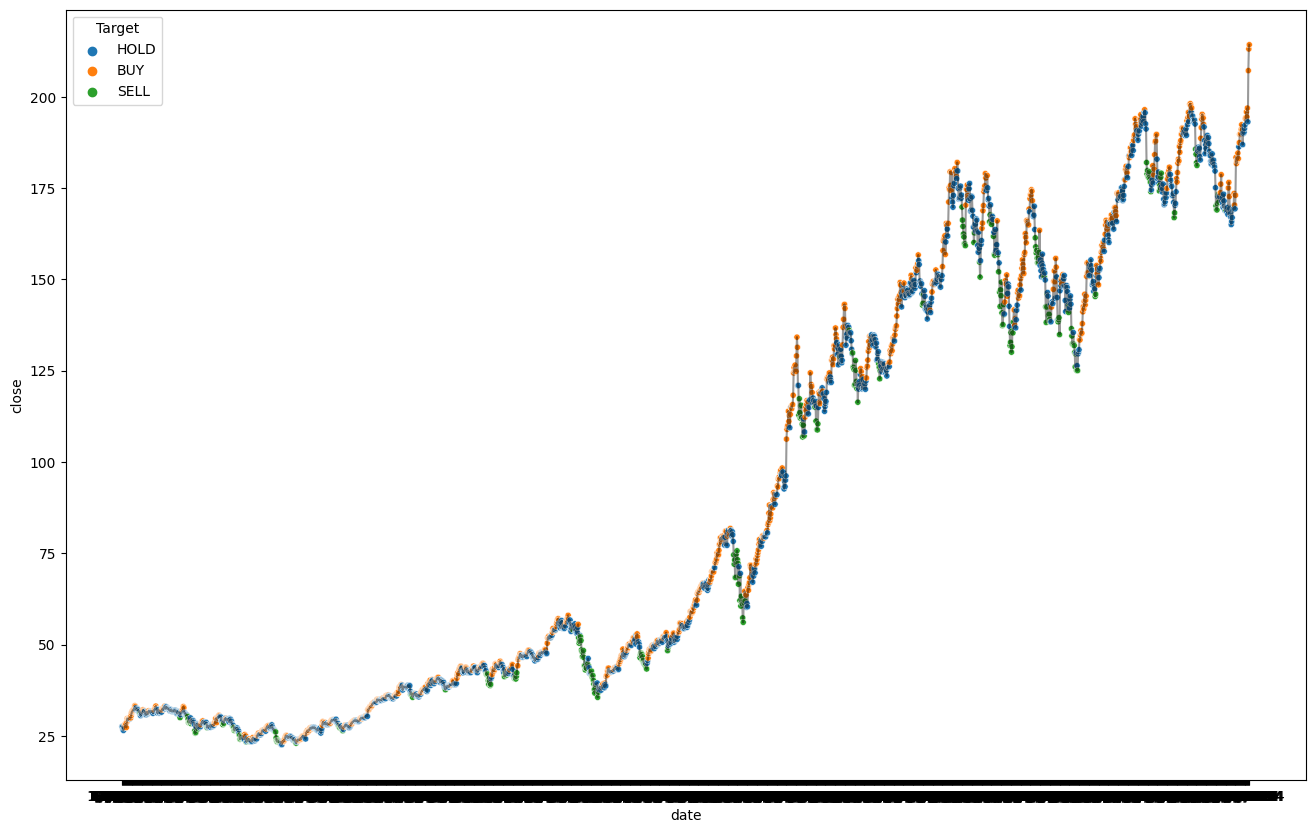

In [61]:

#test_full['price'] = X_test_orig['close'].to_numpy()
#pred_full['price'] = X_test_orig['close'].to_numpy()
#test_full.head()

a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=dtc_predictions, x=dtc_predictions.index, y='close', hue='Target',s=20)

#sns.scatterplot(data=otherdf, x=otherdf.index, y='close', hue='Target', size=0.1 )

### AdaBoost Performance

In [62]:
#AdaBoost Model
calculate_total_gains(adb_predictions, init_value=initial_investment, init_price=adb_predictions['close'][0])

Buying 36 shares for 27.39. Remaining Balance: 14.050000000000068
Selling all shares for 31.13, cash balance: $1134.6400000000003
Buying 35 shares for 32.12. Remaining Balance: 10.527500000000373
Selling all shares for 30.64, cash balance: $1083.0150000000003
Buying 34 shares for 31.40. Remaining Balance: 15.330000000000382
Selling all shares for 30.69, cash balance: $1058.8750000000005
Buying 36 shares for 29.12. Remaining Balance: 10.375000000000455
Selling all shares for 26.44, cash balance: $962.2150000000005
Buying 34 shares for 28.08. Remaining Balance: 7.580000000000496
Selling all shares for 28.11, cash balance: $963.3200000000005
Buying 34 shares for 27.95. Remaining Balance: 13.105000000000473
Selling all shares for 29.03, cash balance: $1000.0400000000004
Buying 33 shares for 29.72. Remaining Balance: 19.280000000000427
Selling all shares for 28.30, cash balance: $953.0150000000004
Buying 37 shares for 25.36. Remaining Balance: 14.88000000000045
Selling all shares for 23.36,

11440.874999999996

<Axes: xlabel='date', ylabel='close'>

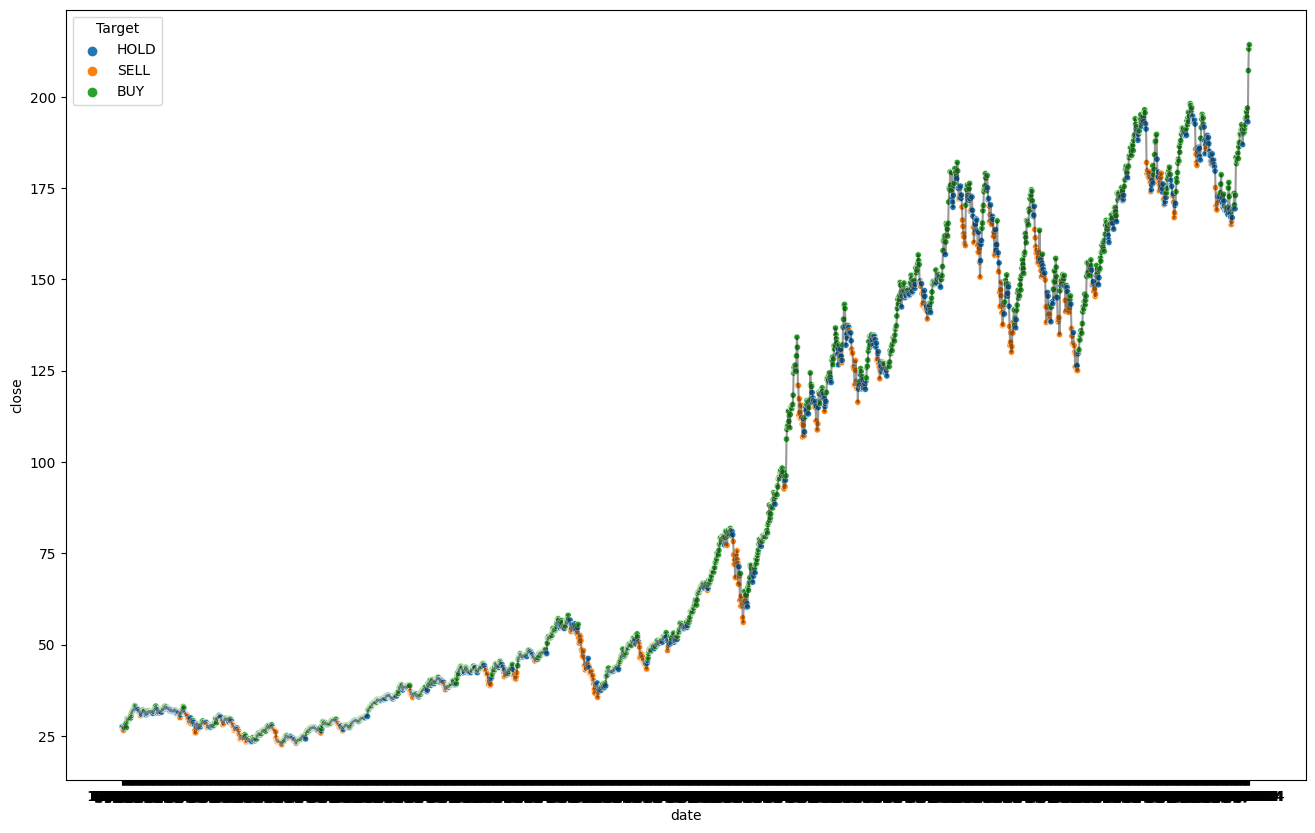

In [63]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=adb_predictions, x=adb_predictions.index, y='close', hue='Target',s=20)

### Gradient Boost Performance

In [64]:
#Gradient Boost
calculate_total_gains(gbc_predictions, init_value=initial_investment, init_price=gbc_predictions['close'][0])

Buying 36 shares for 27.18. Remaining Balance: 21.519999999999982
Selling all shares for 31.45, cash balance: $1153.72
Buying 36 shares for 31.91. Remaining Balance: 5.1400000000001
Selling all shares for 30.02, cash balance: $1085.77
Buying 32 shares for 33.02. Remaining Balance: 29.210000000000036
Selling all shares for 30.69, cash balance: $1011.37
Buying 33 shares for 29.93. Remaining Balance: 23.680000000000064
Selling all shares for 28.37, cash balance: $959.9725
Buying 32 shares for 29.29. Remaining Balance: 22.692499999999995
Selling all shares for 26.44, cash balance: $868.7725
Buying 30 shares for 28.08. Remaining Balance: 26.44749999999999
Selling all shares for 27.27, cash balance: $844.3975
Buying 30 shares for 27.95. Remaining Balance: 5.972499999999968
Selling all shares for 29.19, cash balance: $881.7475
Buying 30 shares for 29.32. Remaining Balance: 2.072499999999877
Selling all shares for 28.91, cash balance: $869.2225
Buying 31 shares for 27.18. Remaining Balance: 26

5369.5650000000005

<Axes: xlabel='date', ylabel='close'>

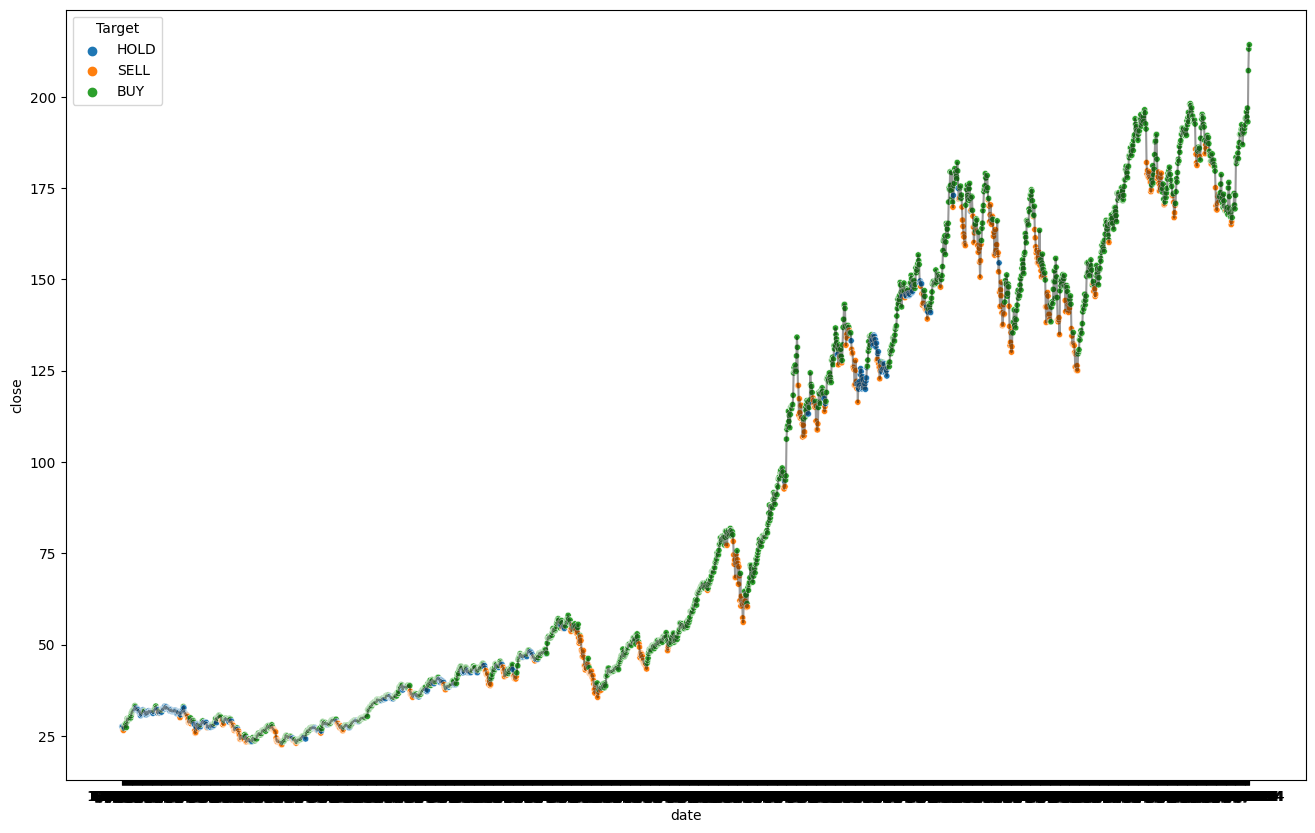

In [65]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=gbc_predictions, x=gbc_predictions.index, y='close', hue='Target',s=20)

### Random Forest Performance

In [66]:
calculate_total_gains(rf_predictions, init_value=initial_investment, init_price=rf_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all shares for 26.70, cash balance: $969.3999999999999
Buying 35 shares for 27.39. Remaining Balance: 10.837499999999864
Selling all shares for 31.13, cash balance: $1100.3
Buying 34 shares for 32.12. Remaining Balance: 8.305000000000064
Selling all shares for 31.29, cash balance: $1072.0800000000002
Buying 33 shares for 32.24. Remaining Balance: 8.242500000000291
Selling all shares for 31.13, cash balance: $1035.6150000000002
Buying 32 shares for 31.40. Remaining Balance: 30.73500000000024
Selling all shares for 31.12, cash balance: $1026.7350000000001
Buying 35 shares for 29.29. Remaining Balance: 1.5850000000002638
Selling all shares for 28.16, cash balance: $987.2725000000003
Buying 35 shares for 28.19. Remaining Balance: 0.6225000000001728
Selling all shares for 26.93, cash balance: $943.1725000000001
Buying 33 shares for 28.09. Remaining Balance: 16.367500000000064
Selling all shares for 28.11, cash balance:

8059.329999999996

<Axes: xlabel='date', ylabel='close'>

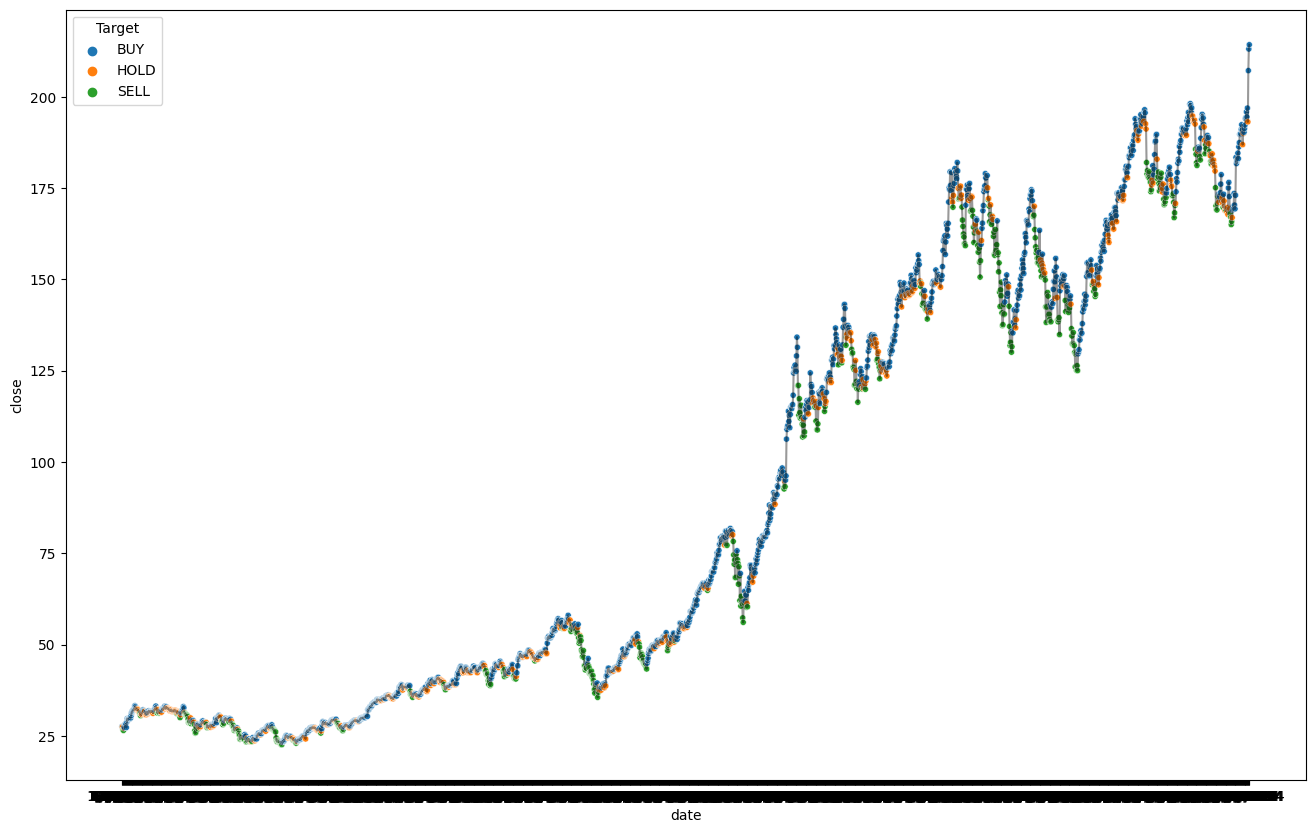

In [67]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=rf_predictions, x=rf_predictions.index, y='close', hue='Target',s=20)

### XGBoost Performance

In [68]:
calculate_total_gains(xgb_predictions, init_value=initial_investment, init_price=xgb_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all shares for 26.70, cash balance: $969.3999999999999
Buying 35 shares for 27.18. Remaining Balance: 18.09999999999991
Selling all shares for 31.13, cash balance: $1107.5625
Buying 34 shares for 31.87. Remaining Balance: 23.85329999999999
Selling all shares for 31.25, cash balance: $1086.4383
Buying 33 shares for 32.85. Remaining Balance: 2.470800000000054
Selling all shares for 30.02, cash balance: $993.0483
Buying 30 shares for 33.02. Remaining Balance: 2.523300000000063
Selling all shares for 30.69, cash balance: $923.2983
Buying 32 shares for 28.08. Remaining Balance: 24.818300000000022
Selling all shares for 27.27, cash balance: $897.2983
Buying 32 shares for 27.95. Remaining Balance: 2.97829999999999
Selling all shares for 29.03, cash balance: $931.8583
Buying 31 shares for 29.70. Remaining Balance: 11.313300000000027
Selling all shares for 28.91, cash balance: $907.3683000000001
Buying 33 shares for 27.18.

6010.8283

<Axes: xlabel='date', ylabel='close'>

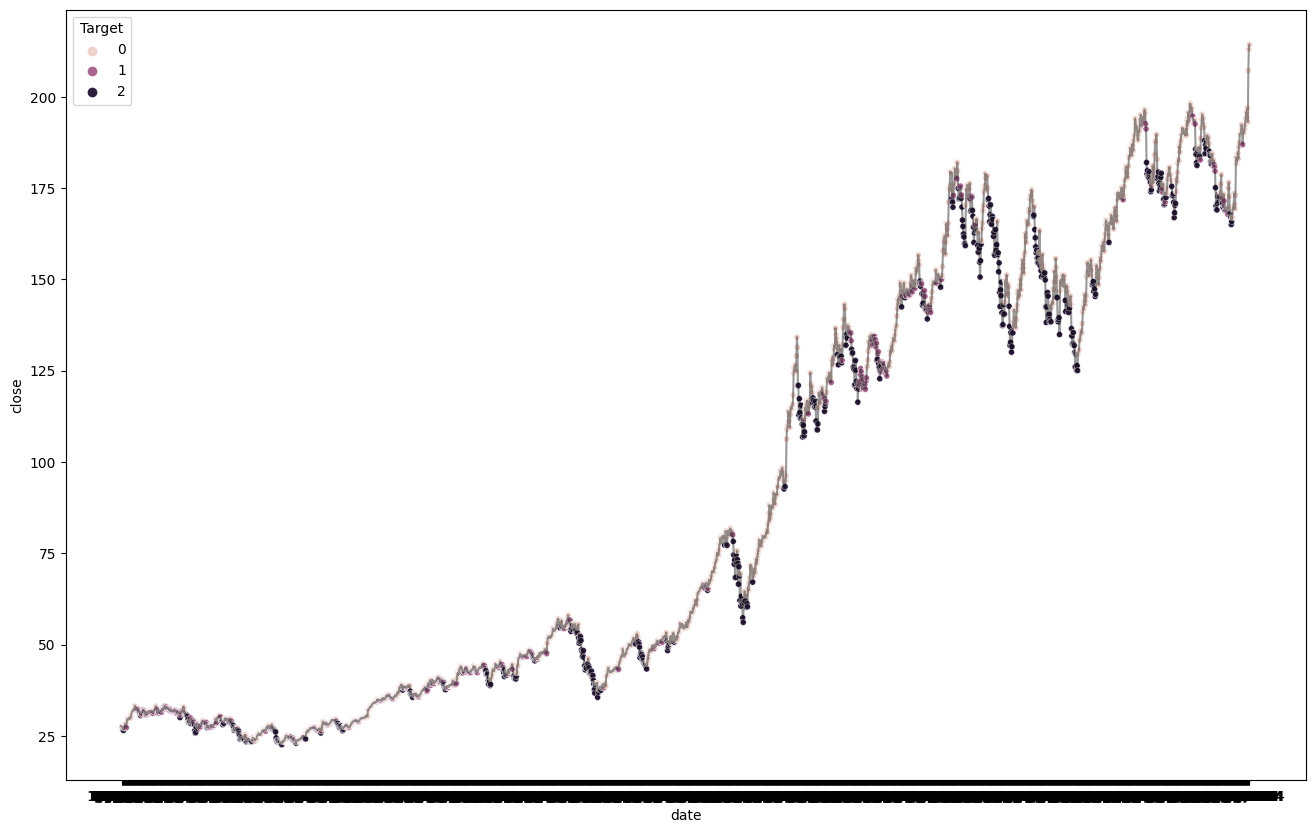

In [69]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_predictions, x=xgb_predictions.index, y='close', hue='Target',s=20)

<Axes: xlabel='date', ylabel='close'>

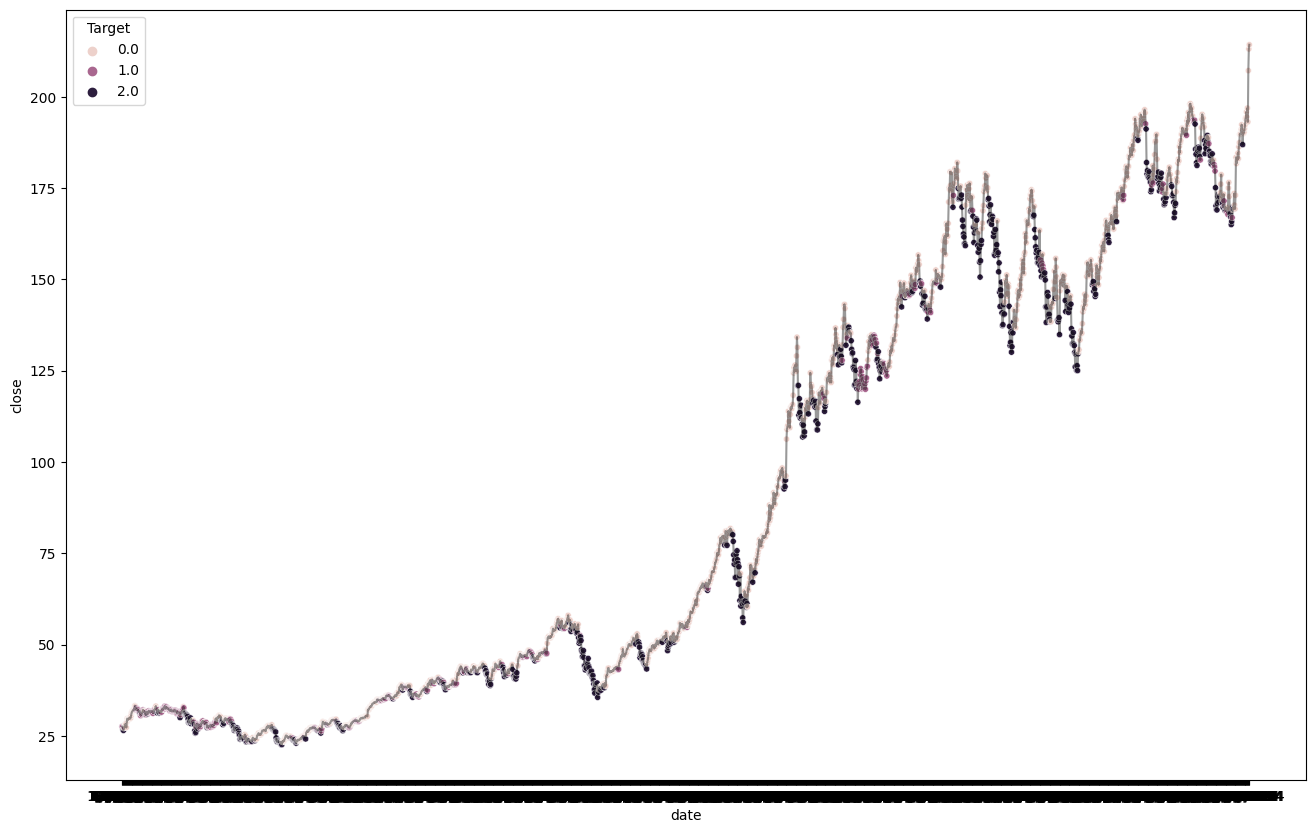

In [70]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_native_predictions, x=xgb_native_predictions.index, y='close', hue='Target',s=20)